In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [6]:
# '맥주'만 빼서 df생성
item = '맥주'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [9]:
# train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = gs_day_w.loc[:,'temp':]
# target = gs_day_w.loc[:,'qty']

##### 날씨 소셜 전부 사용할 시 : 2016~2017년도는 예측 잘함, 2018년도 폭망 => 과적합 발생

# 날씨만 

In [7]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
gs_day_w = gs_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


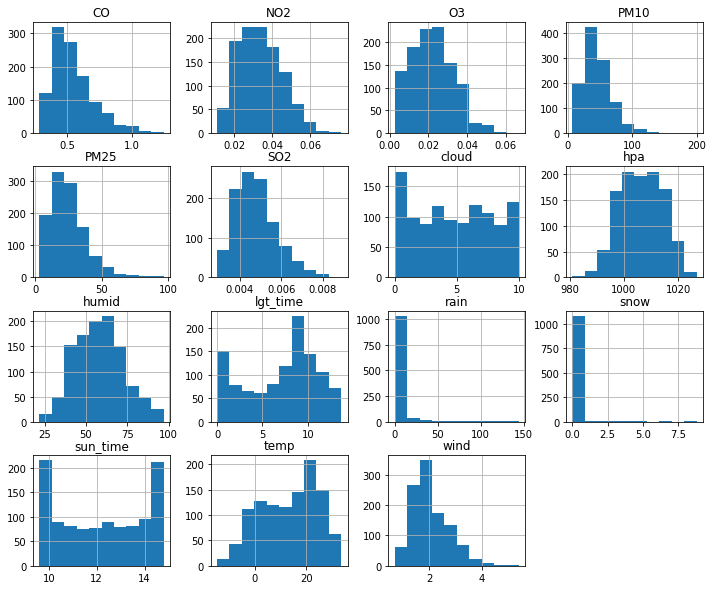

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

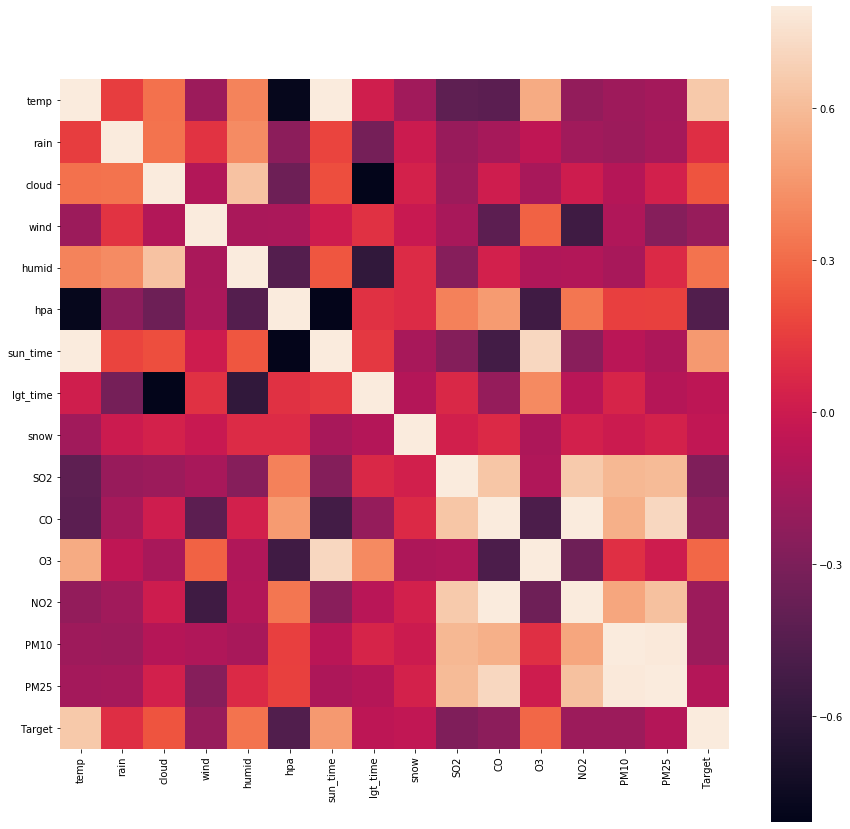

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [13]:
# 이 함수는 경연대회에서 제공된 데이터에 맞춤형이기에, 수치는 내가 필요한 수치로 변경함.
# 2016~2017까지의 날짜수 + 1
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()
train.shape

(732, 15)

In [17]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 14:12:50.279403   864 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 14:12:50.295361   864 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 14:12:50.297356   864 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 14:12:50.353205   864 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpoint_name = 'GS-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [19]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 14:12:53.451603   864 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 14:12:53.565304   864 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 546us/step - loss: 11175.9480 - mean_absolute_error: 11175.9480 - val_loss: 9367.7586 - val_mean_absolute_error: 9367.7586

Epoch 00001: val_loss improved from inf to 9367.75864, saving model to GS-맥주date-Weights-001--9367.75864.hdf5
Epoch 2/500
585/585 [==============================] - 0s 80us/step - loss: 4684.1881 - mean_absolute_error: 4684.1881 - val_loss: 1722.9582 - val_mean_absolute_error: 1722.9582

Epoch 00002: val_loss improved from 9367.75864 to 1722.95823, saving model to GS-맥주date-Weights-002--1722.95823.hdf5
Epoch 3/500
585/585 [==============================] - 0s 80us/step - loss: 2356.0372 - mean_absolute_error: 2356.0372 - val_loss: 1703.2264 - val_mean_absolute_error: 1703.2264

Epoch 00003: val_loss improved from 1722.95823 to 1703.22640, saving model to GS-맥주date-Weights-003--1703.22640.hdf5
Epoch 4/500
585/585 [==============================] - 0s 75us/step - 

585/585 [==============================] - 0s 81us/step - loss: 1629.9096 - mean_absolute_error: 1629.9096 - val_loss: 1310.7827 - val_mean_absolute_error: 1310.7827

Epoch 00032: val_loss did not improve from 1304.52919
Epoch 33/500
585/585 [==============================] - 0s 70us/step - loss: 1599.7674 - mean_absolute_error: 1599.7674 - val_loss: 1354.6626 - val_mean_absolute_error: 1354.6626

Epoch 00033: val_loss did not improve from 1304.52919
Epoch 34/500
585/585 [==============================] - 0s 86us/step - loss: 1617.2421 - mean_absolute_error: 1617.2421 - val_loss: 1353.5941 - val_mean_absolute_error: 1353.5941

Epoch 00034: val_loss did not improve from 1304.52919
Epoch 35/500
585/585 [==============================] - 0s 80us/step - loss: 1687.0831 - mean_absolute_error: 1687.0831 - val_loss: 1325.6576 - val_mean_absolute_error: 1325.6576

Epoch 00035: val_loss did not improve from 1304.52919
Epoch 36/500
585/585 [==============================] - 0s 75us/step - loss: 

585/585 [==============================] - 0s 97us/step - loss: 1590.7299 - mean_absolute_error: 1590.7299 - val_loss: 1341.3145 - val_mean_absolute_error: 1341.3145

Epoch 00066: val_loss did not improve from 1286.45240
Epoch 67/500
585/585 [==============================] - 0s 90us/step - loss: 1634.7082 - mean_absolute_error: 1634.7082 - val_loss: 1315.0479 - val_mean_absolute_error: 1315.0479

Epoch 00067: val_loss did not improve from 1286.45240
Epoch 68/500
585/585 [==============================] - 0s 104us/step - loss: 1595.7318 - mean_absolute_error: 1595.7318 - val_loss: 1291.1375 - val_mean_absolute_error: 1291.1375

Epoch 00068: val_loss did not improve from 1286.45240
Epoch 69/500
585/585 [==============================] - 0s 73us/step - loss: 1602.8356 - mean_absolute_error: 1602.8356 - val_loss: 1310.2481 - val_mean_absolute_error: 1310.2481

Epoch 00069: val_loss did not improve from 1286.45240
Epoch 70/500
585/585 [==============================] - 0s 75us/step - loss:

585/585 [==============================] - 0s 82us/step - loss: 1549.7018 - mean_absolute_error: 1549.7018 - val_loss: 1280.4201 - val_mean_absolute_error: 1280.4201

Epoch 00100: val_loss did not improve from 1273.48966
Epoch 101/500
585/585 [==============================] - 0s 87us/step - loss: 1663.0317 - mean_absolute_error: 1663.0317 - val_loss: 1311.8490 - val_mean_absolute_error: 1311.8490

Epoch 00101: val_loss did not improve from 1273.48966
Epoch 102/500
585/585 [==============================] - 0s 75us/step - loss: 1645.1738 - mean_absolute_error: 1645.1738 - val_loss: 1437.5767 - val_mean_absolute_error: 1437.5767

Epoch 00102: val_loss did not improve from 1273.48966
Epoch 103/500
585/585 [==============================] - 0s 109us/step - loss: 1585.0671 - mean_absolute_error: 1585.0671 - val_loss: 1296.2487 - val_mean_absolute_error: 1296.2487

Epoch 00103: val_loss did not improve from 1273.48966
Epoch 104/500
585/585 [==============================] - 0s 84us/step - l


Epoch 00134: val_loss did not improve from 1273.05239
Epoch 135/500
585/585 [==============================] - 0s 78us/step - loss: 1566.8510 - mean_absolute_error: 1566.8510 - val_loss: 1282.7797 - val_mean_absolute_error: 1282.7797

Epoch 00135: val_loss did not improve from 1273.05239
Epoch 136/500
585/585 [==============================] - 0s 77us/step - loss: 1569.5762 - mean_absolute_error: 1569.5762 - val_loss: 1306.2690 - val_mean_absolute_error: 1306.2690

Epoch 00136: val_loss did not improve from 1273.05239
Epoch 137/500
585/585 [==============================] - 0s 124us/step - loss: 1563.8442 - mean_absolute_error: 1563.8442 - val_loss: 1307.0931 - val_mean_absolute_error: 1307.0931

Epoch 00137: val_loss did not improve from 1273.05239
Epoch 138/500
585/585 [==============================] - 0s 97us/step - loss: 1561.4615 - mean_absolute_error: 1561.4615 - val_loss: 1271.2645 - val_mean_absolute_error: 1271.2645

Epoch 00138: val_loss improved from 1273.05239 to 1271.264

585/585 [==============================] - 0s 85us/step - loss: 1531.9968 - mean_absolute_error: 1531.9968 - val_loss: 1281.2071 - val_mean_absolute_error: 1281.2071

Epoch 00169: val_loss did not improve from 1269.77364
Epoch 170/500
585/585 [==============================] - 0s 94us/step - loss: 1562.9208 - mean_absolute_error: 1562.9208 - val_loss: 1323.8841 - val_mean_absolute_error: 1323.8841

Epoch 00170: val_loss did not improve from 1269.77364
Epoch 171/500
585/585 [==============================] - 0s 78us/step - loss: 1518.7386 - mean_absolute_error: 1518.7386 - val_loss: 1279.3096 - val_mean_absolute_error: 1279.3096

Epoch 00171: val_loss did not improve from 1269.77364
Epoch 172/500
585/585 [==============================] - 0s 82us/step - loss: 1536.4362 - mean_absolute_error: 1536.4362 - val_loss: 1272.3628 - val_mean_absolute_error: 1272.3628

Epoch 00172: val_loss did not improve from 1269.77364
Epoch 173/500
585/585 [==============================] - 0s 78us/step - lo

585/585 [==============================] - 0s 84us/step - loss: 1564.8511 - mean_absolute_error: 1564.8511 - val_loss: 1269.4919 - val_mean_absolute_error: 1269.4919

Epoch 00203: val_loss did not improve from 1267.00262
Epoch 204/500
585/585 [==============================] - 0s 86us/step - loss: 1539.5399 - mean_absolute_error: 1539.5399 - val_loss: 1277.4281 - val_mean_absolute_error: 1277.4281

Epoch 00204: val_loss did not improve from 1267.00262
Epoch 205/500
585/585 [==============================] - 0s 85us/step - loss: 1548.0539 - mean_absolute_error: 1548.0539 - val_loss: 1284.8421 - val_mean_absolute_error: 1284.8421

Epoch 00205: val_loss did not improve from 1267.00262
Epoch 206/500
585/585 [==============================] - 0s 85us/step - loss: 1548.2200 - mean_absolute_error: 1548.2200 - val_loss: 1359.1405 - val_mean_absolute_error: 1359.1405

Epoch 00206: val_loss did not improve from 1267.00262
Epoch 207/500
585/585 [==============================] - 0s 109us/step - l

585/585 [==============================] - 0s 101us/step - loss: 1546.5854 - mean_absolute_error: 1546.5854 - val_loss: 1283.6699 - val_mean_absolute_error: 1283.6699

Epoch 00238: val_loss did not improve from 1267.00262
Epoch 239/500
585/585 [==============================] - 0s 92us/step - loss: 1515.7911 - mean_absolute_error: 1515.7911 - val_loss: 1286.3578 - val_mean_absolute_error: 1286.3578

Epoch 00239: val_loss did not improve from 1267.00262
Epoch 240/500
585/585 [==============================] - 0s 92us/step - loss: 1514.6502 - mean_absolute_error: 1514.6502 - val_loss: 1313.8815 - val_mean_absolute_error: 1313.8815

Epoch 00240: val_loss did not improve from 1267.00262
Epoch 241/500
585/585 [==============================] - 0s 92us/step - loss: 1524.9059 - mean_absolute_error: 1524.9059 - val_loss: 1337.1321 - val_mean_absolute_error: 1337.1321

Epoch 00241: val_loss did not improve from 1267.00262
Epoch 242/500
585/585 [==============================] - 0s 106us/step - 

585/585 [==============================] - 0s 107us/step - loss: 1531.5124 - mean_absolute_error: 1531.5124 - val_loss: 1263.1994 - val_mean_absolute_error: 1263.1994

Epoch 00273: val_loss improved from 1267.00262 to 1263.19940, saving model to GS-맥주date-Weights-273--1263.19940.hdf5
Epoch 274/500
585/585 [==============================] - 0s 113us/step - loss: 1532.9707 - mean_absolute_error: 1532.9707 - val_loss: 1284.8921 - val_mean_absolute_error: 1284.8921

Epoch 00274: val_loss did not improve from 1263.19940
Epoch 275/500
585/585 [==============================] - 0s 104us/step - loss: 1570.0839 - mean_absolute_error: 1570.0839 - val_loss: 1289.6840 - val_mean_absolute_error: 1289.6840

Epoch 00275: val_loss did not improve from 1263.19940
Epoch 276/500
585/585 [==============================] - 0s 99us/step - loss: 1588.5485 - mean_absolute_error: 1588.5485 - val_loss: 1270.9975 - val_mean_absolute_error: 1270.9975

Epoch 00276: val_loss did not improve from 1263.19940
Epoch 27


Epoch 00306: val_loss did not improve from 1257.18437
Epoch 307/500
585/585 [==============================] - 0s 99us/step - loss: 1496.5914 - mean_absolute_error: 1496.5914 - val_loss: 1283.1208 - val_mean_absolute_error: 1283.1208

Epoch 00307: val_loss did not improve from 1257.18437
Epoch 308/500
585/585 [==============================] - 0s 107us/step - loss: 1571.1050 - mean_absolute_error: 1571.1050 - val_loss: 1278.8787 - val_mean_absolute_error: 1278.8787

Epoch 00308: val_loss did not improve from 1257.18437
Epoch 309/500
585/585 [==============================] - 0s 116us/step - loss: 1568.7629 - mean_absolute_error: 1568.7629 - val_loss: 1353.0696 - val_mean_absolute_error: 1353.0696

Epoch 00309: val_loss did not improve from 1257.18437
Epoch 310/500
585/585 [==============================] - 0s 121us/step - loss: 1589.5207 - mean_absolute_error: 1589.5207 - val_loss: 1262.7358 - val_mean_absolute_error: 1262.7358

Epoch 00310: val_loss did not improve from 1257.18437
Ep

585/585 [==============================] - 0s 128us/step - loss: 1548.6358 - mean_absolute_error: 1548.6358 - val_loss: 1310.5580 - val_mean_absolute_error: 1310.5580

Epoch 00341: val_loss did not improve from 1247.14514
Epoch 342/500
585/585 [==============================] - 0s 126us/step - loss: 1504.4201 - mean_absolute_error: 1504.4201 - val_loss: 1421.4071 - val_mean_absolute_error: 1421.4071

Epoch 00342: val_loss did not improve from 1247.14514
Epoch 343/500
585/585 [==============================] - 0s 128us/step - loss: 1498.6816 - mean_absolute_error: 1498.6816 - val_loss: 1339.2051 - val_mean_absolute_error: 1339.2051

Epoch 00343: val_loss did not improve from 1247.14514
Epoch 344/500
585/585 [==============================] - 0s 126us/step - loss: 1498.0358 - mean_absolute_error: 1498.0358 - val_loss: 1438.8507 - val_mean_absolute_error: 1438.8507

Epoch 00344: val_loss did not improve from 1247.14514
Epoch 345/500
585/585 [==============================] - 0s 118us/step

585/585 [==============================] - 0s 123us/step - loss: 1493.6149 - mean_absolute_error: 1493.6149 - val_loss: 1310.7796 - val_mean_absolute_error: 1310.7796

Epoch 00376: val_loss did not improve from 1247.14514
Epoch 377/500
585/585 [==============================] - 0s 120us/step - loss: 1519.0613 - mean_absolute_error: 1519.0613 - val_loss: 1420.5921 - val_mean_absolute_error: 1420.5921

Epoch 00377: val_loss did not improve from 1247.14514
Epoch 378/500
585/585 [==============================] - 0s 122us/step - loss: 1486.2576 - mean_absolute_error: 1486.2576 - val_loss: 1357.7118 - val_mean_absolute_error: 1357.7118

Epoch 00378: val_loss did not improve from 1247.14514
Epoch 379/500
585/585 [==============================] - 0s 126us/step - loss: 1520.9389 - mean_absolute_error: 1520.9389 - val_loss: 1371.8302 - val_mean_absolute_error: 1371.8302

Epoch 00379: val_loss did not improve from 1247.14514
Epoch 380/500
585/585 [==============================] - 0s 123us/step


Epoch 00410: val_loss did not improve from 1237.10886
Epoch 411/500
585/585 [==============================] - 0s 115us/step - loss: 1500.9564 - mean_absolute_error: 1500.9564 - val_loss: 1255.8946 - val_mean_absolute_error: 1255.8946

Epoch 00411: val_loss did not improve from 1237.10886
Epoch 412/500
585/585 [==============================] - 0s 128us/step - loss: 1479.6999 - mean_absolute_error: 1479.6999 - val_loss: 1273.3054 - val_mean_absolute_error: 1273.3054

Epoch 00412: val_loss did not improve from 1237.10886
Epoch 413/500
585/585 [==============================] - 0s 151us/step - loss: 1488.9380 - mean_absolute_error: 1488.9380 - val_loss: 1395.3113 - val_mean_absolute_error: 1395.3113

Epoch 00413: val_loss did not improve from 1237.10886
Epoch 414/500
585/585 [==============================] - 0s 152us/step - loss: 1509.6369 - mean_absolute_error: 1509.6369 - val_loss: 1887.7723 - val_mean_absolute_error: 1887.7723

Epoch 00414: val_loss did not improve from 1237.10886
E

585/585 [==============================] - 0s 176us/step - loss: 1484.5584 - mean_absolute_error: 1484.5584 - val_loss: 1362.3094 - val_mean_absolute_error: 1362.3094

Epoch 00445: val_loss did not improve from 1237.10886
Epoch 446/500
585/585 [==============================] - 0s 170us/step - loss: 1487.8443 - mean_absolute_error: 1487.8443 - val_loss: 1324.5014 - val_mean_absolute_error: 1324.5014

Epoch 00446: val_loss did not improve from 1237.10886
Epoch 447/500
585/585 [==============================] - 0s 170us/step - loss: 1497.3047 - mean_absolute_error: 1497.3047 - val_loss: 1246.2346 - val_mean_absolute_error: 1246.2346

Epoch 00447: val_loss did not improve from 1237.10886
Epoch 448/500
585/585 [==============================] - 0s 191us/step - loss: 1532.0590 - mean_absolute_error: 1532.0590 - val_loss: 1468.9075 - val_mean_absolute_error: 1468.9075

Epoch 00448: val_loss did not improve from 1237.10886
Epoch 449/500
585/585 [==============================] - 0s 196us/step

585/585 [==============================] - 0s 148us/step - loss: 1493.6361 - mean_absolute_error: 1493.6361 - val_loss: 1480.1577 - val_mean_absolute_error: 1480.1577

Epoch 00480: val_loss did not improve from 1237.10886
Epoch 481/500
585/585 [==============================] - 0s 136us/step - loss: 1485.1399 - mean_absolute_error: 1485.1399 - val_loss: 1501.8105 - val_mean_absolute_error: 1501.8105

Epoch 00481: val_loss did not improve from 1237.10886
Epoch 482/500
585/585 [==============================] - 0s 154us/step - loss: 1477.9416 - mean_absolute_error: 1477.9416 - val_loss: 1381.5267 - val_mean_absolute_error: 1381.5267

Epoch 00482: val_loss did not improve from 1237.10886
Epoch 483/500
585/585 [==============================] - 0s 157us/step - loss: 1509.9056 - mean_absolute_error: 1509.9056 - val_loss: 1317.3779 - val_mean_absolute_error: 1317.3779

Epoch 00483: val_loss did not improve from 1237.10886
Epoch 484/500
585/585 [==============================] - 0s 159us/step

In [20]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
wights_file = 'GS-맥주date-Weights-406--1237.10886.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [21]:
# rf나,XGB회귀 분석을위한 훈련/검증 dataset생산
train_X, val_X, train_y, val_y = train_test_split(train, target[:732], test_size = 0.25, random_state = 14)

In [22]:
# RandomForest 회귀분석
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  1543.8306010928961


In [23]:
# XGBRegressor 회귀분석
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[14:14:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  1455.4847752305327


In [25]:
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = gs_day_w.loc[:,'qty']
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1096, 1)
randomforest 예상 (1096,)
XGBpredictions (1096,)


In [26]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

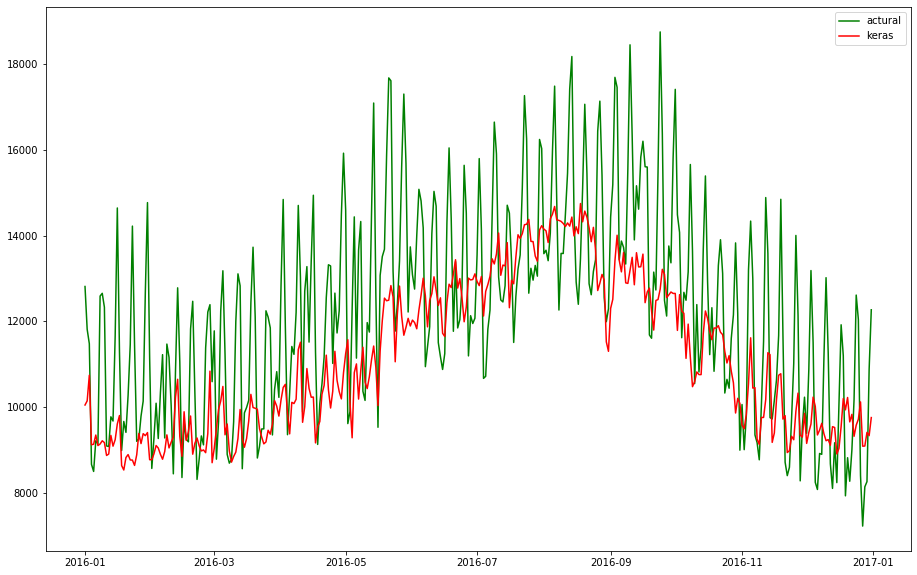

In [27]:
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green')
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

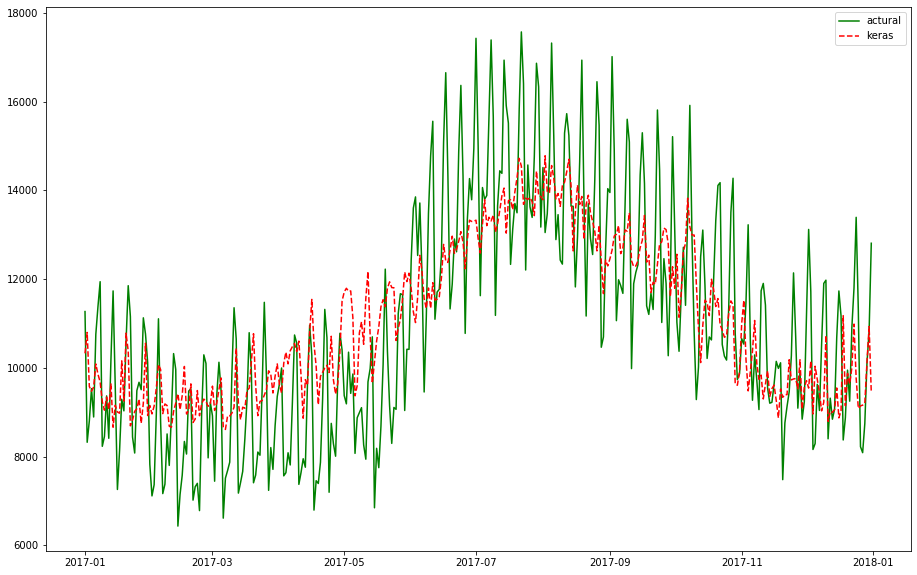

In [28]:
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green')
plt.plot(df_graph.date,df_graph.keras_qty, ls='--', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

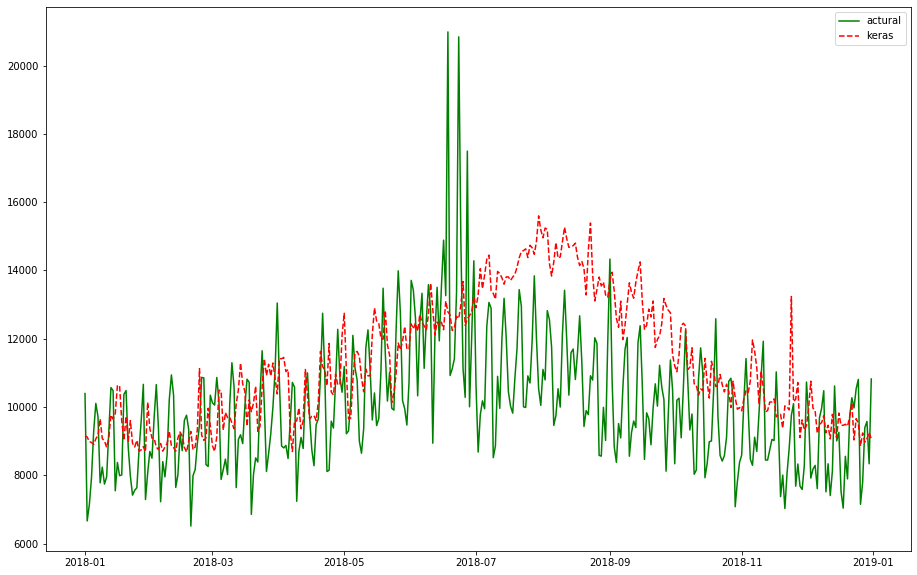

In [29]:
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green')
plt.plot(df_graph.date,df_graph.keras_qty, ls='--', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

In [30]:
result_df['qtyMinusMean'] = (result_df.qty-np.mean(result_df.qty) )
result_df['qtyMinusMeanSquared'] = (result_df.qty-np.mean(result_df.qty) )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty-np.mean(result_df.qty))**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty-np.mean(result_df.qty))**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty-np.mean(result_df.qty))**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.5246089914017266
rf R-sq 0.8249914565159663
xgb R-sq 0.7027038096039221


In [31]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)